In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# Задача со звездочкой 8: Экспоненциальный шум

Придумать и реализовать более умную оптимизацию линейной регрессии с экспоненциальным шумом, чем полным перебором по пространству весов. Правильный ответ должен быть **неотличим на глаз** от предсказаний модели.

In [2]:
def f_true(x):

    return (x - 3) ** 2

In [3]:
x = np.linspace(1, 10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2.0, len(x_observed))

# Полиномиальный базис
def get_design(x):
    return np.vstack((np.ones_like(x), x, x**2)).T

X_observed = get_design(x_observed)

Минимизируем отклонения с помощью scipy minimize

Принцип работы:
1. Предсказываем 0.1-й квантиль, модель будет стремиться к тому, чтобы 90% значений находились выше предсказания и 10% — ниже.
2. Если остаток положительный, модель наказывает его с коэффициентом quantile.
3. Если остаток отрицательный, модель наказывает его с коэффициентом quantile, что означает, что недооценка штрафуется сильнее для меньших квантилей.

Это позволяет сделать модель устойчивой к выбросам и отклонениям предсказанных значений от истинных.

In [4]:
def quantile_loss(w, X, y, quantile=0.1):

    preds = X @ w
    residuals = y - preds
    return np.sum(np.maximum(quantile * residuals, (quantile - 1) * residuals))


w = np.zeros(X_observed.shape[1])

optimizer = minimize(
    quantile_loss, w, args=(X_observed, y_observed), method="BFGS"
)

optimized_weights = optimizer.x

Text(0, 0.5, 'y')

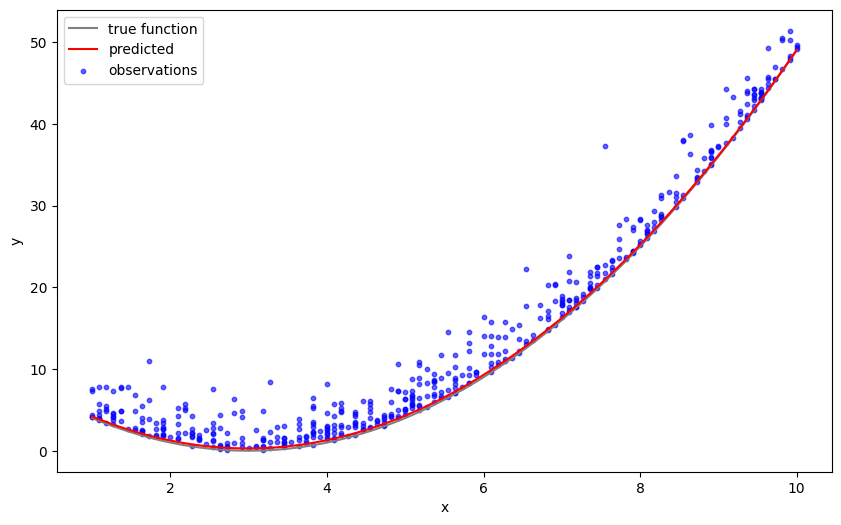

In [5]:
X_pred = get_design(x)
y_pred = X_pred @ optimized_weights

plt.figure(figsize=(10, 6))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, y_pred, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=10, c="blue", alpha=0.6, label="observations")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")

# Задача со звездочкой 9: Эллипс
Вы оказались одни в лесу, и вам очень надо восстановить уравнение эллипса по данным. Как на зло, все что у вас есть - это sklearn.linear_model.LinearRegression.

## 1 балл. К счастью, вы знаете что эллипс не абы какой, а с осями, параллельными осям координат.

In [6]:
# Правильный ответ
CENTER_X = -5.0
CENTER_Y = 2.0
SCALE_X = 2.0
SCALE_Y = 3.0
ANGLE = np.pi / 6

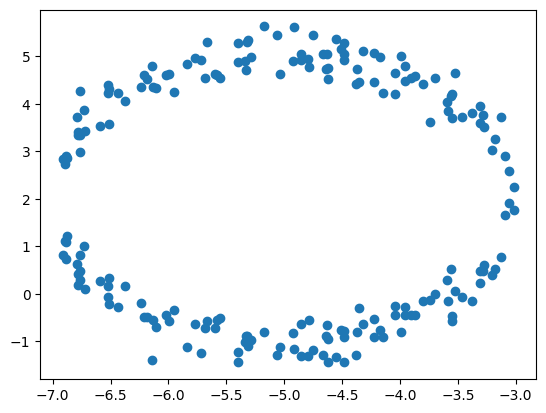

In [7]:
# Генерируем данные
x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X + CENTER_X
y = y * SCALE_Y + CENTER_Y
x = np.hstack([x, x])
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])

Эллипс с осями, параллельными осям кооринат как кривая второго порядка:
$$ Ax^2 + By^2 + Cx + Dy + E = 0 $$

Преобразуем данные для обучения

In [8]:
def get_design(data):
    return np.column_stack(
        [data[:, 0] ** 2, data[:, 1] ** 2, data[:, 0], data[:, 1]]
    )

Обучаем модель и получаем коэффициенты
fit_intercept=False позволяет получить нетривиальное решение (все коэффициенты 0)

In [9]:
regr = LinearRegression(fit_intercept=False)
regr.fit(get_design(data), np.ones_like(data[:, 0]))

A, B, C, D = regr.coef_

Зная коэффициенты, находим центр эллипса и полуоснования a и b.

https://en.wikipedia.org/wiki/Ellipse#Parametric_representation

In [10]:
h = -C / (2 * A)
k = -D / (2 * B)
E = -1

polynom = A * h**2 + B * k**2 + C * h + D * k + E

a = np.sqrt(-polynom / A)
b = np.sqrt(-polynom / B)

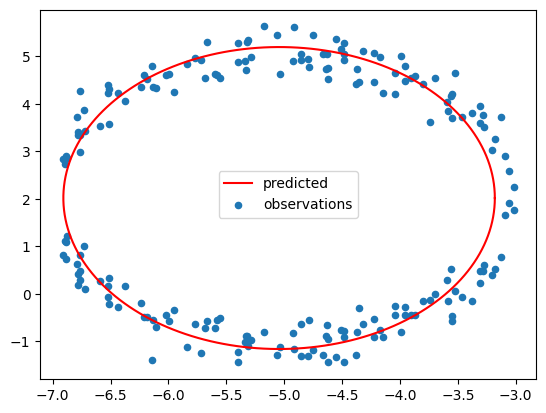

In [11]:
theta = np.linspace(0, 2 * np.pi, 200)

# Параметрические ур-я эллипса для начертания
x_param = h + a * np.cos(theta)
y_param = k + b * np.sin(theta)

plt.plot(x_param, y_param, c="red", label="predicted")
plt.scatter(data[:, 0], data[:, 1], s=20.0, label="observations")
plt.legend()

## 1 балл. А теперь не знаете. (WARNING: я не уверен в том, что это возможно c LinearRegression, но OLS может)

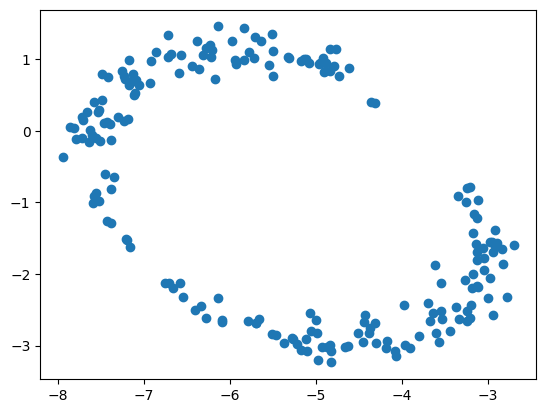

In [12]:
# Генерируем данные
x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X + CENTER_X
y = y * SCALE_Y + CENTER_Y
x = np.hstack([x, x])

# Добавляем угол наклона
cos = np.cos(ANGLE)
sin = np.sin(ANGLE)
x = cos * x - sin * y
y = sin * x + cos * y
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])

Общее уравнение эллипса, как кривой второго порядка:
$$ Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0 $$
Аналогично первому пункту:

In [13]:
def get_design(data):
    return np.column_stack(
        [data[:, 0] ** 2, data[:, 0]* data[:, 1], data[:, 1] ** 2, data[:, 0], data[:, 1]]
    )

regr = LinearRegression(fit_intercept=False)

regr.fit(get_design(data), np.ones_like(data[:, 0]))


A, B, C, D, E = regr.coef_
F = -1

Находим параметры эллипса, используя коэффициенты. Все тот же сайт вики, раздел General ellipse:
https://en.wikipedia.org/wiki/Ellipse#Parametric_representation

In [14]:
h = (2 * C * D - B * E) / (B**2 - 4 * A * C)
k = (2 * A * E - B * D) / (B**2 - 4 * A * C)

print(h, k)

theta = 0.5 * np.arctan2(B, A - C)

print(theta)

cos = np.cos(theta)
sin = np.sin(theta)

A_coef = A * cos**2 + B * cos * sin + C * sin**2
C_coef = A * sin**2 - B * cos * sin + C * cos**2

polynom = A * h**2 + B * h * k + C * k**2 + D * h + E * k + F

a = np.sqrt(-polynom / A_coef)
b = np.sqrt(-polynom / C_coef)

-5.345013299035056 -0.9329464846078626
-0.7037467420346604


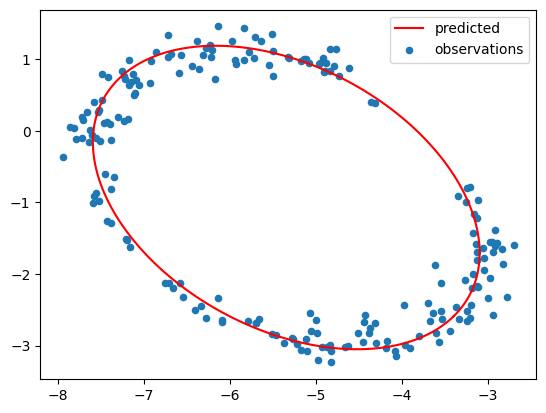

In [15]:
theta = np.linspace(0, 2 * np.pi, 200)

# Параметрическое ур-е
x = a * np.cos(theta)
y = b * np.sin(theta)

# Евклидова трансформация
x_param = cos * x - sin * y + h
y_param = sin * x + cos * y + k

plt.plot(x_param, y_param, c="red", label="predicted")
plt.scatter(data[:, 0], data[:, 1], s=20.0, label="observations")
plt.legend()